In [1]:
# %load imports.txt
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('../../../')

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Imports & Constants

In [2]:
import os
from collections import defaultdict

from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from pyro.infer.autoguide import AutoDelta
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score

from src.learning.svi import train_svi
from src.models.base.bayesian_logistic_regression import BayesianLogisticRegression
from src.datasets.load_datasets import load_continuous_for_bayesian_logistic_regression
from src.predictors.svi_predictor import predict
from src.experiments.base_experiment import k_fold_experiment
from src.settings import DATA_DIR, REPORT_DIR, RESULT_DIR

In [3]:
CONTINUOUS_DATASET_PATH = os.path.join(DATA_DIR, 'datasets', 'diabetes-continuous.csv')

PLOT_PATH = os.path.join(REPORT_DIR, 'figures', 'blr')

# Experiments

In [4]:
X, y = load_continuous_for_bayesian_logistic_regression(CONTINUOUS_DATASET_PATH)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [6]:
model = BayesianLogisticRegression(8)
guide = AutoDelta(model)

In [7]:
history = train_svi(model, guide, X_train, y_train, lr=0.003, num_epochs=1000)

Epoch = 0, Loss = 352.399450302124
Epoch = 50, Loss = 310.6777448654175
Epoch = 100, Loss = 289.50376892089844
Epoch = 150, Loss = 278.63128995895386
Epoch = 200, Loss = 271.90176343917847
Epoch = 250, Loss = 267.04455375671387
Epoch = 300, Loss = 263.34830236434937
Epoch = 350, Loss = 260.5210180282593
Epoch = 400, Loss = 258.3722519874573
Epoch = 450, Loss = 256.7511715888977
Epoch = 500, Loss = 255.53666925430298
Epoch = 550, Loss = 254.63293981552124
Epoch = 600, Loss = 253.9653615951538
Epoch = 650, Loss = 253.4760913848877
Epoch = 700, Loss = 253.12069416046143
Epoch = 750, Loss = 252.8650860786438
Epoch = 800, Loss = 252.68316316604614
Epoch = 850, Loss = 252.55512142181396
Epoch = 900, Loss = 252.46610307693481
Epoch = 950, Loss = 252.40506792068481
Epoch = 999, Loss = 252.36440324783325


In [8]:
predictions = predict(model, guide, X_test, return_sites=('obs',), confidence_factor=1.645)

In [9]:
THRESHOLD = .3

results = pd.DataFrame()
results['Mean'] = predictions['obs']['mean']
results['Prediction'] = predictions['obs']['mean'] >= THRESHOLD
results['Std'] = predictions['obs']['std']
results['LowerConfidence'] = predictions['obs']['lower_confidence']
results['UpperConfidence'] = predictions['obs']['upper_confidence']
results['ConfidenceInterval'] = predictions['obs']['confidence_range']
results['True'] = y_test.numpy()
results['Glucose'] = X_test[:, 1].numpy()
results['Insuline'] = X_test[:, 4].numpy()
results['BloodPressure'] = X_test[:, 2].numpy()
results['Class'] = results['True'].replace({0: 'Normal', 1: 'Diabetic'})
results.head()

Mean  Prediction       Std  LowerConfidence  UpperConfidence  \
0  0.254       False  0.435515        -0.058013         0.566013   
1  0.192       False  0.394070        -0.063454         0.447454   
2  0.091       False  0.287753        -0.045209         0.227209   
3  0.117       False  0.321581        -0.053117         0.287117   
4  0.467        True  0.499159         0.057132         0.876868   

   ConfidenceInterval  True   Glucose  Insuline  BloodPressure   Class  
0            0.624026   0.0 -0.777694  0.571411      -1.190090  Normal  
1            0.510908   0.0 -0.317447 -0.181541       0.216174  Normal  
2            0.272418   0.0 -0.448946 -0.181541      -0.693761  Normal  
3            0.340233   0.0 -0.481821 -0.181541       0.629782  Normal  
4            0.819737   0.0  0.471547 -0.181541       1.456996  Normal

In [10]:
print('Shape', results.shape)
print('Accuracy:', accuracy_score(results['True'].to_numpy(), results['Prediction'].to_numpy()))
print('F1-score:', f1_score(results['True'].to_numpy(), results['Prediction'].to_numpy()))

Shape (231, 11)
Accuracy: 0.7056277056277056
F1-score: 0.6382978723404256


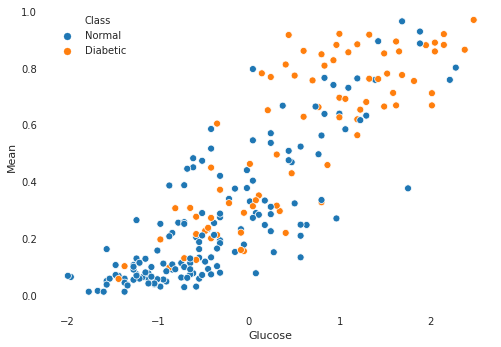

In [11]:
sns.scatterplot('Glucose', 'Mean', 'Class', data=results)
plt.savefig(PLOT_PATH + f'/blr_glucose_all.png')

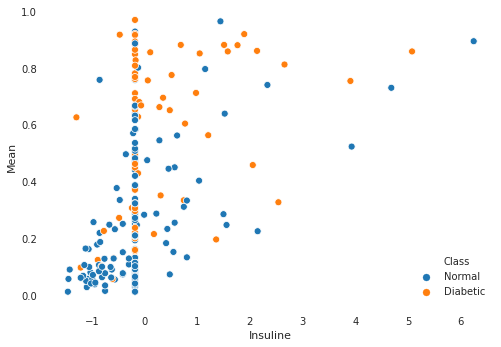

In [12]:
sns.scatterplot('Insuline', 'Mean', 'Class', data=results)
plt.savefig(PLOT_PATH + f'/blr_insulin_all.png')

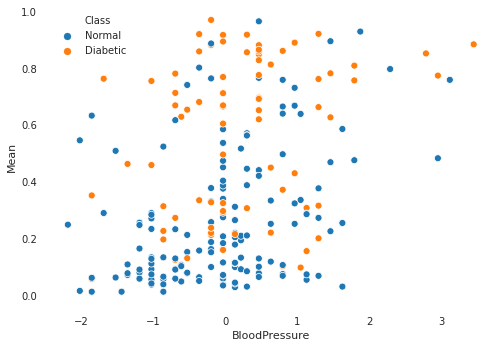

In [13]:
sns.scatterplot('BloodPressure', 'Mean', 'Class', data=results)
plt.savefig(PLOT_PATH + f'/blr_blood_all.png')

In [14]:
CONFIDENCE_INTERVAL = .6

results2 = results[(((results.LowerConfidence < THRESHOLD) 
                    & (results.UpperConfidence < THRESHOLD))
                   | ((results.LowerConfidence >= THRESHOLD) 
                    & (results.UpperConfidence >= THRESHOLD))) 
                   & (results.ConfidenceInterval < CONFIDENCE_INTERVAL)]

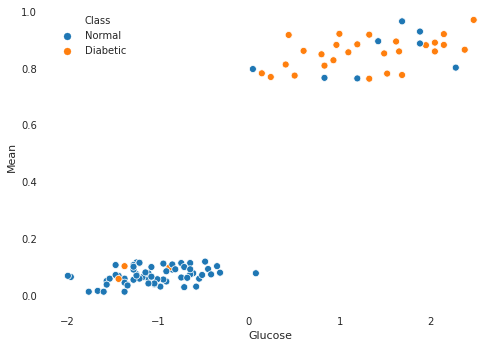

In [15]:
sns.scatterplot('Glucose', 'Mean', 'Class', data=results2)
plt.savefig(PLOT_PATH + f'/blr_glucose_best.png')

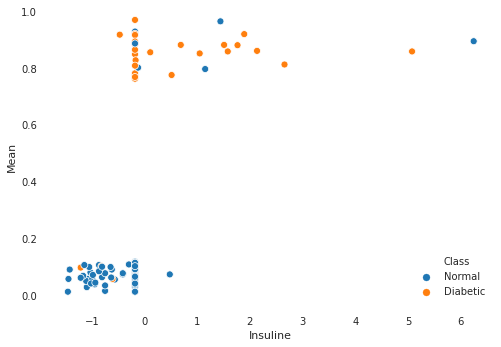

In [16]:
sns.scatterplot('Insuline', 'Mean', 'Class', data=results2)
plt.savefig(PLOT_PATH + f'/blr_insulin_best.png')

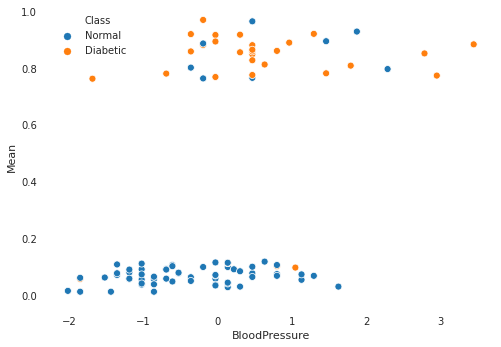

In [17]:
sns.scatterplot('BloodPressure', 'Mean', 'Class', data=results2)
plt.savefig(PLOT_PATH + f'/blr_blood_best.png')

In [18]:
print('Shape', results2.shape)
print('Accuracy:', accuracy_score(results2['True'].to_numpy(), results2['Prediction'].to_numpy()))
print('F1-score:', f1_score(results2['True'].to_numpy(), results2['Prediction'].to_numpy()))

Shape (100, 11)
Accuracy: 0.88
F1-score: 0.8181818181818182


In [19]:
df_params = pd.DataFrame()
df_params['Attributes'] = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
df_params['Weights'] = history['params']['AutoDelta.linear.weight'][-1].squeeze(0)
df_params

Attributes   Weights
0               Pregnancies  0.198495
1                   Glucose  1.129603
2             BloodPressure -0.095167
3             SkinThickness  0.038513
4                   Insulin -0.020897
5                       BMI  0.724851
6  DiabetesPedigreeFunction  0.109959
7                       Age  0.390542

Bias -0.8479341


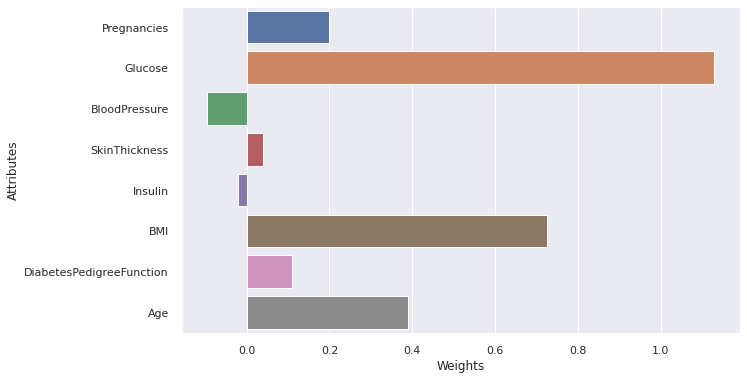

In [20]:
print('Bias', history['params']['AutoDelta.linear.bias'][-1][0])

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.barplot(y="Attributes", x="Weights", data=df_params)
plt.savefig(PLOT_PATH + f'/blr_params.png')

# Score test

In [21]:
def train_func(X_train, y_train, X_test, y_test, threshold = .5, confidence_range = None):
    model = BayesianLogisticRegression(8)
    guide = AutoDelta(model)
    
    history = train_svi(model, guide, X_train, y_train, lr=0.003, num_epochs=1000, interval=None)
    pred_summary = predict(model, guide, X_test, return_sites=("obs", ))
    
    results = pd.DataFrame()
    results['Mean'] = pred_summary['obs']['mean']
    results['Prediction'] = (pred_summary['obs']['mean'] >= threshold).float().numpy()
    results['Std'] = pred_summary['obs']['std']
    results['LowerConfidence'] = pred_summary['obs']['lower_confidence']
    results['UpperConfidence'] = pred_summary['obs']['upper_confidence']
    results['ConfidenceRange'] = pred_summary['obs']['confidence_range']
    results['True'] = y_test.numpy()
        
    if confidence_range is not None:
        results = results[(results.ConfidenceRange < confidence_range)]
    
    y_pred = results['Prediction']
    y_true = results['True']
    
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
    }

In [22]:
def experiment():
    results = defaultdict(list)
    for th in [.2, .3, .4, .5, .6]:
        for cr in [None, 3, .4, .5, .6, .7]:
            history = k_fold_experiment(
                lambda x1, y1, x2, y2: train_func(
                    x1, y1, x2, y2,
                    threshold = th,
                    confidence_range = cr
                ),
                X,
                y,
                n_splits=5,
            )
            avg_metrics = defaultdict(list)

            for h in history:
                for k in h:
                    avg_metrics[k].append(h[k])

            results['Threshold'].append(th)
            results['ConfidenceRange'].append(cr)
            for k in avg_metrics:
                results[k + '_mean'].append(np.mean(avg_metrics[k]))
                results[k + '_std'].append(np.std(avg_metrics[k]))
                results[k].append(f"{np.mean(avg_metrics[k]):.2%} ± {np.std(avg_metrics[k]):.2%}")
                
    return pd.DataFrame.from_dict(results)



df_results = experiment()

In [23]:
def plot_heatmap(name):
    temp = pd.DataFrame()
    temp['Threshold'] = df_results['Threshold']
    temp['ConfidenceRange'] = df_results['ConfidenceRange']
    temp['Labels'] = df_results[name]
    temp[name] = df_results[f'{name}_mean']

    temp_data = temp.pivot(index='Threshold', columns='ConfidenceRange', values=name)
    temp_labels = temp.pivot(index='Threshold', columns='ConfidenceRange', values='Labels')

    plt.figure(figsize=(16, 10))
    sns.heatmap(temp_data, annot=temp_labels.to_numpy(), fmt='', cmap="YlGnBu")
    
    plt.savefig(PLOT_PATH + f'/blr_{name}.png')

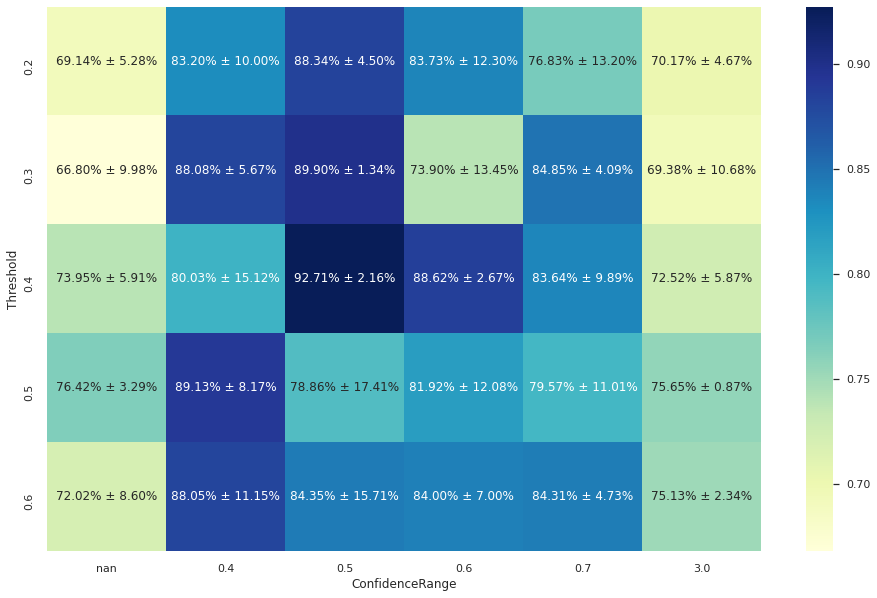

In [24]:
plot_heatmap('Accuracy')

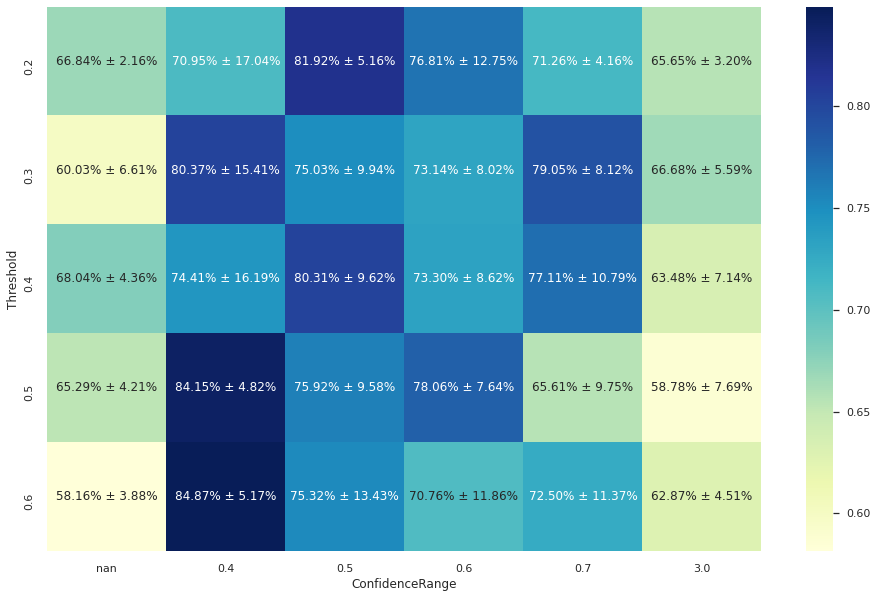

In [25]:
plot_heatmap('F1-score')

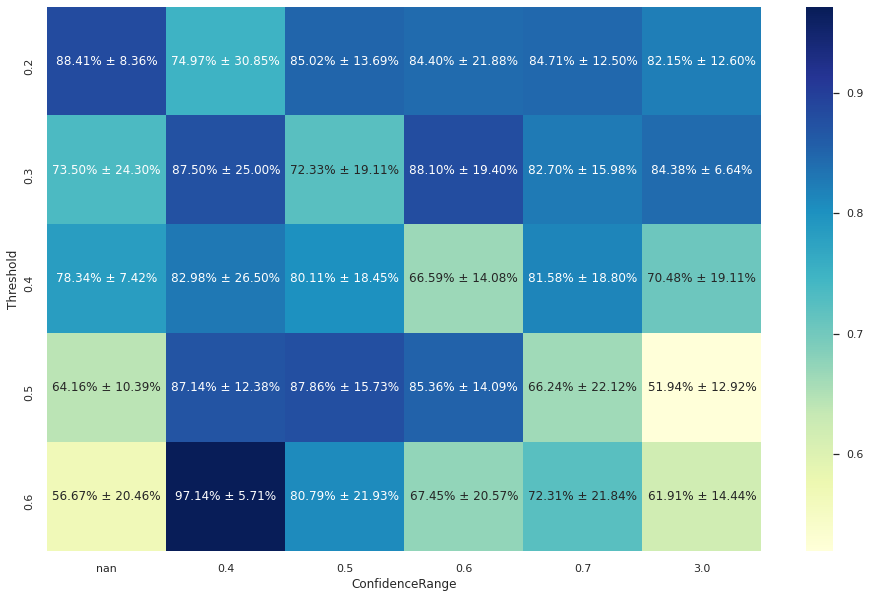

In [26]:
plot_heatmap('Recall')

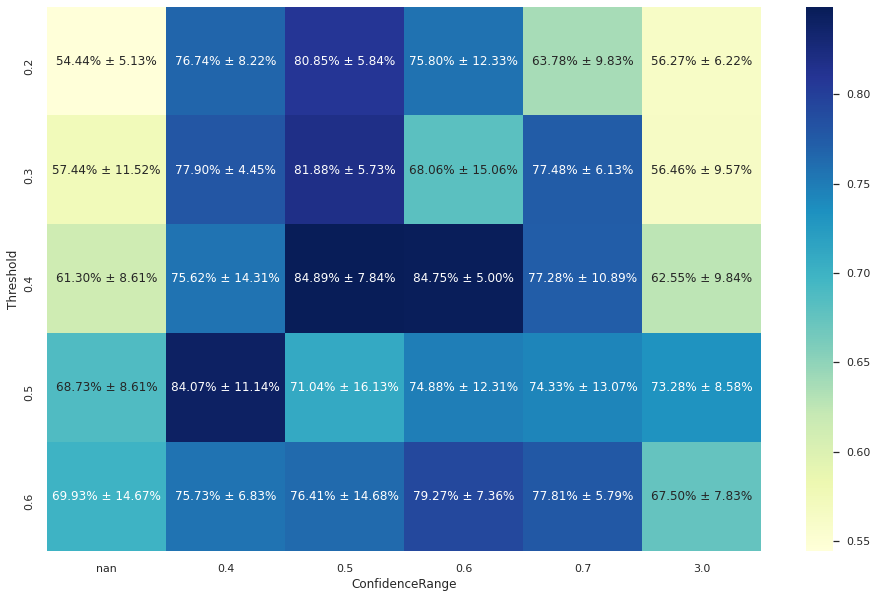

In [27]:
plot_heatmap('Precision')